In [1136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings('ignore')

#### Datasets

In [1137]:
import os
for dirname, _, filenames in os.walk('./input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
 

./input/real_estate_price_prediction_moscow\gb_submit.csv
./input/real_estate_price_prediction_moscow\sample_submission.csv
./input/real_estate_price_prediction_moscow\test.csv
./input/real_estate_price_prediction_moscow\train.csv


In [1138]:
    TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
    TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'

#### Auxiliary functions

In [1139]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [1140]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Loading Train and Test

In [1141]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [1142]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [1143]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

#### Target distribution

In [1144]:
train_df.describe().T

count           mean            std           min  \
Id             10000.0    8383.407700    4859.019020      0.000000   
DistrictId     10000.0      50.400800      43.587592      0.000000   
Rooms          10000.0       1.890500       0.839522      0.000000   
Square         10000.0      56.315720      21.058716      1.136859   
LifeSquare      7887.0      37.199665      86.241219      0.370619   
KitchenSquare  10000.0       6.273300      28.560839      0.000000   
Floor          10000.0       8.526700       5.241148      1.000000   
HouseFloor     10000.0      12.609400       6.776200      0.000000   
HouseYear      10000.0    3990.166300  200500.261427   1910.000000   
Ecology_1      10000.0       0.118858       0.119025      0.000000   
Social_1       10000.0      24.687000      17.532614      0.000000   
Social_2       10000.0    5352.157400    4006.799803    168.000000   
Social_3       10000.0       8.039200      23.831875      0.000000   
Healthcare_1    5202.0    1142.904419    1021.519470      0.000000   
Helthcare_2    10000.0       1.319500       1.493601      0.000000   
Shops_1        10000.0       4.231300       4.806341      0.000000   
Price          10000.0  214138.937500   92872.273438  59174.777344   

                         25%            50%            75%           max  
Id               4169.500000    8394.500000   12592.500000  1.679800e+04  
DistrictId         20.000000      36.000000      75.000000  2.090000e+02  
Rooms               1.000000       2.000000       2.000000  1.900000e+01  
Square             41.774879      52.513309      65.900627  6.410652e+02  
LifeSquare         22.769833      32.781261      45.128803  7.480592e+03  
KitchenSquare       1.000000       6.000000       9.000000  2.014000e+03  
Floor               4.000000       7.000000      12.000000  4.200000e+01  
HouseFloor          9.000000      13.000000      17.000000  1.170000e+02  
HouseYear        1974.000000    1977.000000    2001.000000  2.005201e+07  
Ecology_1           0.017647       0.075424       0.195781  5.218670e-01  
Social_1            6.000000      25.000000      36.000000  7.400000e+01  
Social_2         1564.000000    5285.000000    7227.000000  1.908300e+04  
Social_3            0.000000       2.000000       5.000000  1.410000e+02  
Healthcare_1      350.000000     900.000000    1548.000000  4.849000e+03  
Helthcare_2         0.000000       1.000000       2.000000  6.000000e+00  
Shops_1             1.000000       3.000000       6.000000  2.300000e+01  
Price          153872.628906  192269.648438  249135.460938  6.332334e+05

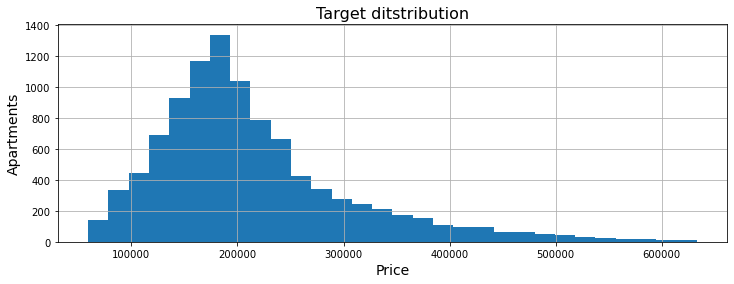

In [1145]:
plt.figure(figsize=(12, 4))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Apartments', fontsize=14)
plt.title('Target ditstribution', fontsize=16)

plt.show()

#### Correlation

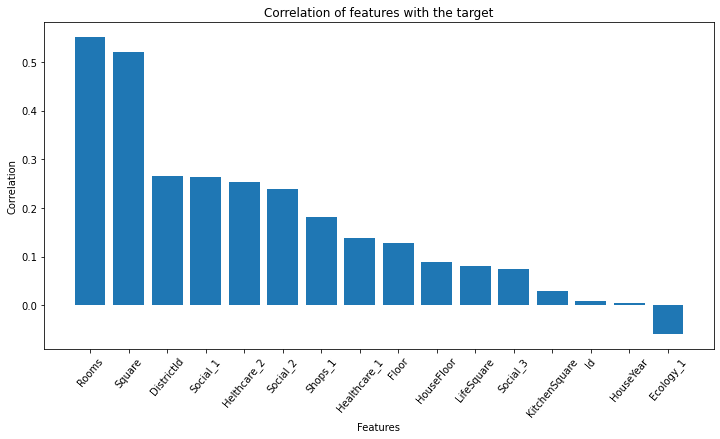

In [1146]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=50)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of features with the target')

plt.show()

In [1147]:
train_df['Id'] = train_df['Id'].astype(str)

In [1148]:
train_df.head(60)

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0   11809          27    3.0  115.027313         NaN           10.0      4   
1    3013          22    1.0   39.832523   23.169222            8.0      7   
2    8215           1    3.0   78.342216   47.671970           10.0      2   
3    2352           1    1.0   40.409908         NaN            1.0     10   
4   13866          94    2.0   64.285065   38.562515            9.0     16   
5    5804          99    3.0   62.528465   47.103832            6.0      9   
6    8864          44    1.0   33.938751   21.772930            9.0      1   
7   13072          59    2.0   50.391815   32.893257            8.0      8   
8    9951           1    1.0   46.887894   44.628132            1.0     12   
9    8094           6    3.0   79.867477   75.085129            1.0      3   
10    535           2    3.0   74.199051   44.735889           10.0      5   
11  16755          88    2.0   53.975143   34.153584            8.0      2   
12    898          93    1.0   47.564442   23.574423           13.0      9   
13   3526          90    2.0   43.871025   26.114386            5.0      5   
14    191          36    3.0   81.994789   43.688797           10.0      2   
15   4328          96    1.0   36.673409   16.285522            9.0      3   
16  11942          48    1.0   44.825249   24.240046            8.0      7   
17   1190           8    2.0   49.396000   28.299601            5.0      6   
18   4581           1    1.0   47.582481         NaN            1.0     16   
19    367          45    1.0   42.367290   40.012527            1.0     16   
20   8768          63    1.0   50.974892         NaN            1.0      7   
21   8471          20    3.0   75.611061   47.494621            8.0     11   
22   1550           7    3.0   86.326363   46.097240           10.0      3   
23  13427         103    1.0   38.174328   23.123014            9.0      6   
24   4717          27    1.0   44.203945         NaN            0.0      2   
25   4521           6    2.0   65.409966         NaN            1.0     18   
26   8553          88    3.0   83.262527    4.769175            1.0     13   
27   1403          67    2.0   52.966915   33.793335            8.0     13   
28   1924          24    1.0   34.127060   19.435738            6.0      5   
29   5273          23    2.0   53.199650   32.459053            9.0      3   
30   5931          23    1.0   43.033398         NaN            1.0      3   
31  13084          38    1.0   47.837631   22.297739            1.0     21   
32   3876         100    4.0  104.769020   79.316650            8.0      4   
33    847          74    2.0   73.314972   74.131264            1.0      7   
34   7757          27    2.0   58.783661   55.441257           11.0     13   
35   3961          23    2.0   65.832954         NaN            1.0     11   
36     57          35    2.0   46.760178   29.829147            6.0      4   
37   1699           9    1.0   78.936165   76.746651            1.0      8   
38   7679          23    2.0   55.521797         NaN            0.0      3   
39   3736         167    2.0   56.712772   36.454063            7.0      6   
40  10954         119    1.0   32.994995   17.717022            5.0      4   
41   7161         129    3.0   80.916443   52.861786            8.0      2   
42   8576           4    2.0   53.179790   50.643795            5.0      5   
43   3486          62    1.0   33.071808   22.237242            6.0      2   
44   9024           6    3.0   79.790764         NaN            1.0     16   
45   8007         173    2.0   44.577221   31.533701            5.0      3   
46   6728          37    4.0   99.154060   66.567192            9.0     18   
47   6186           1    1.0   62.006077         NaN            1.0      7   
48  12307          60    1.0   40.064915   38.733288            8.0     13   
49   5474         111    2.0   63.791065   40.757587           10.0     16   
50   9629         124    3.0 

### Emissions

#### Numerical features

In [1149]:
num_f = list(train_df.select_dtypes(exclude='object').columns)

#### Categorical features

In [1150]:
str_f = list(train_df.select_dtypes(include='object').columns)

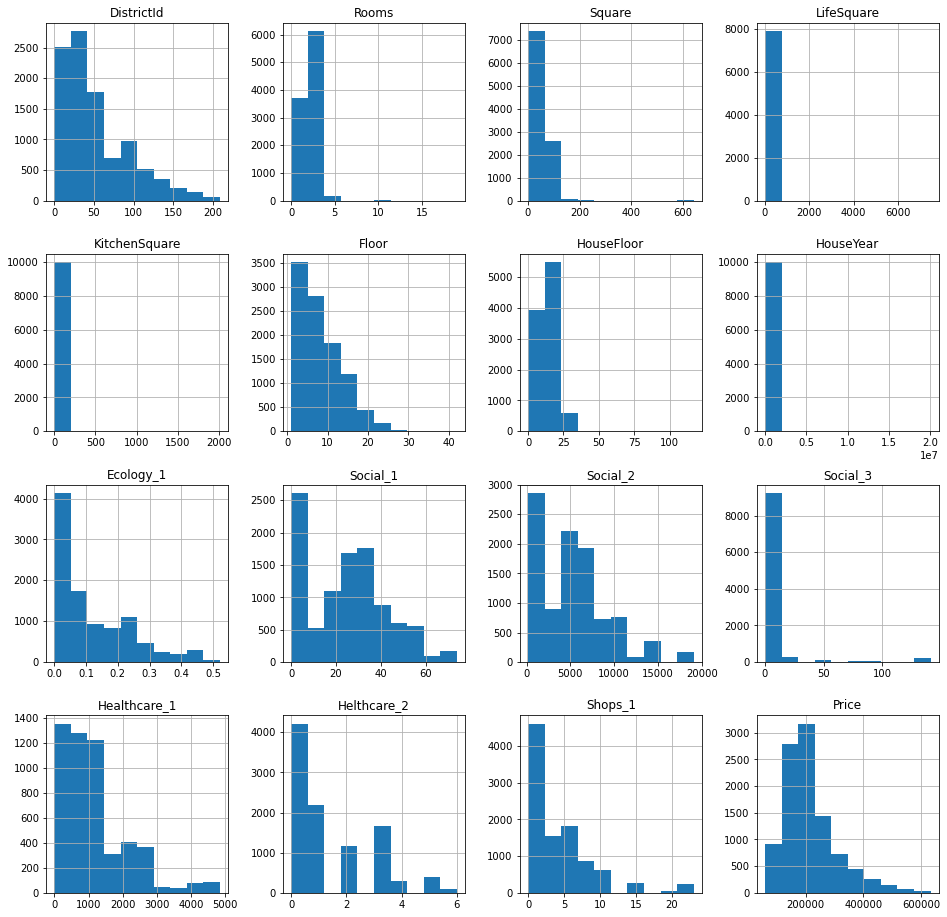

In [1151]:
train_df[num_f].hist(figsize=(16, 16))
plt.show()

### DataPreprocessor

In [1152]:
class DataPreprocessor:
    
    def __init__(self):
        self.medians = None
        self.min_kitchen_square = None
        self.districts_healthcare = None
        self.mean_h1_district = None
        self.med_kitchen_district = None
        self.med_life_sq_dist_rm = None

    
    def fit(self, X):
        # Medians, means, min
        self.medians = X.median()
        
        self.min_kitchen_square = np.quantile(X['KitchenSquare'], q=0.001)
        
        self.mean_h1_district = X.groupby('DistrictId')['Healthcare_1'].mean().to_dict()
        
        self.med_kitchen_district = X.groupby('DistrictId')['KitchenSquare'].median().to_dict()
        
        self.med_life_sq_dist_rm = X.groupby(['DistrictId', 'Rooms'], as_index=False)['LifeSquare'].median()\
        .rename(columns={'LifeSquare': 'life_id_room_median'})
        
    def transform(self, X):
        # LifeSquare
        
        ## add column with median LifeSquare by DistrictId and Rooms
        X = X.merge(self.med_life_sq_dist_rm, on=['DistrictId', 'Rooms'], how='left')
        
        condition_life = X['LifeSquare'].isna()
        ## NaN --> LifeSquare = life_id_room_median
        X.loc[condition_life, 'LifeSquare'] = X.loc[condition_life, 'life_id_room_median']

        ## NaN (if 'life_id_room_median' = NaN) --> 0.92 * Square - Kitchen
        X['LifeSquare'].fillna(X['Square'] * .92 - X['KitchenSquare'], inplace=True)

        
        # Rooms
        condition_rooms = (X['Rooms'] >= 6) | (X['Rooms'] == 0)
        
        ## Square of the room
        rooms_district = X.groupby(['DistrictId'])['Rooms']
        room_sq_median =  X['LifeSquare'].median() / self.medians['Rooms']
        X.loc[condition_rooms, 'Rooms'] =  X.loc[condition_rooms, 'LifeSquare'] / room_sq_median

        
        # Square

        ## Square < KitchenSquare --> Square <=> KitchenSquare (if KitchenSquare <= 250 (--> for Square this max))
        X['Square'], X['KitchenSquare'] = np.where(
            (X['Square'] <= X['KitchenSquare']) & (X['KitchenSquare'] <= 250),
            (X['KitchenSquare'], X['Square']), (X['Square'], X['KitchenSquare'])
        )

        ## Square < LifeSquare --> Square <=> LifeSquare 
        X['Square'], X['LifeSquare'] = np.where(
            X['Square'] < X['LifeSquare'], (X['LifeSquare'], X['Square']), (X['Square'], X['LifeSquare'])
        )
        
        
        # KitchenSquare
        ## Outliers --> Square - LifeSquare - 3
        condition_kitchen_square = (X['KitchenSquare'] > 60) | (X['KitchenSquare'] < self.min_kitchen_square)

        X.loc[condition_kitchen_square, 'KitchenSquare'] = \
        X.loc[condition_kitchen_square, 'Square'] - X.loc[condition_kitchen_square, 'LifeSquare'] - 3
        
        
        # Ecology and Shops
        ## Switch to binary
        binary_to_numbers = {'A': 0, 'B': 1}
        
        X.replace({
            'Ecology_2': binary_to_numbers,
            'Ecology_3': binary_to_numbers,
            'Shops_2': binary_to_numbers
        }, inplace=True)
        
        
        # Floor
        ## Min Floor
        train_df.loc[train_df['Floor'] < 1, 'Floor'] = 1
        
        
        # HouseFloor
        ## HouseFloor < Floor --> HouseFloor = Floor
        condition_house_floor = X['HouseFloor'] < X['Floor'] 
        X.loc[condition_house_floor, 'HouseFloor'] = X.loc[condition_house_floor, 'Floor']


        # HouseYear
        ## HouseYear > current year --> median year
        condition_year = X['HouseYear'] > 2021
        X.loc[condition_year, 'HouseYear'] = self.medians['HouseYear']
        
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.mean_h1_district)
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        healthcare_1_quntile_max = np.quantile(X['Healthcare_1'], q=0.95)
        X.loc[X['Healthcare_1'] > healthcare_1_quntile_max, 'Healthcare_1'] = healthcare_1_quntile_max
    
    
        # remove cols
        X.drop(columns=['life_id_room_median'], inplace=True)
    
    
        # Fillna
        X.fillna(self.medians, inplace=True)

    
        return X

### FeatureGenerator

In [1153]:
class FeatureGenerator:
    
    def __init__(self):
        self.district_median_year = None
        self.district_density = None
        self.district_price_square = None
        self.min_square = None
        self.max_square = None
        self.district_size = None
        self.median_district_size = None
        self.healthcare_1_min = None
        self.healthcare_1_max = None
        self.shops_1_max = None
    
    def fit(self, X, y=None):
        X = X.copy()
        
        self.district_size = X['DistrictId'].value_counts().reset_index() \
        .rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        
        self.median_district_size = self.district_size['DistrictSize'].median()
        
        self.districts_median_year = X.groupby('DistrictId')['HouseYear'].median().to_dict()
        self.district_square = X.groupby('DistrictId')['Square'].median().to_dict()        

        self.min_square = np.quantile(X['Square'], q=0.005)
        self.max_square = np.quantile(X['Square'], q=0.9994)\
        
        self.healthcare_1_max = X['Healthcare_1'].max()
        self.shops_1_max = X['Shops_1'].max()
        
        # Target encoding
        if y is not None:
            df = X.copy()
            df['Price'] = y.values
            
            self.district_price_square = \
            df.groupby('DistrictId')['Price'].median() / df.groupby('DistrictId')['Square'].median()

        
        
    def transform(self, X):
        # DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X.loc[X['DistrictSize'].isna(), 'DistrictSize'] = self.median_district_size
        
        # DistrictYear
        X['DistrictYear'] = X['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = X['DistrictYear'].median()
        X['DistrictYear'].fillna(self.median_district_year, inplace=True)
        
        # DistrictSquare
        X['DistrictSquare'] = X['DistrictId'].map(self.district_square)
        
        self.median_district_square = X['DistrictId'].median()
        X['DistrictSquare'].fillna(self.median_district_square, inplace=True)
        
        # DistrictPrice
        self.district_price_square.to_dict()
        X['DistrictPrice'] = X['DistrictId'].map(self.district_price_square)
        
        self.median_district_price_square = X['DistrictPrice'].median()
        X['DistrictPrice'].fillna(self.median_district_price_square, inplace=True)
        
        # Floor_cat
        floor_bins = [0, 4, 8, 12, X['Floor'].max()]
        X['Floor_cat'] = pd.cut(X['Floor'], bins=floor_bins, labels=False)
        X['Floor_cat'].fillna(-1, inplace=True)

        
        # Scaler
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        
        # Social scale
        social_scale = pd.DataFrame(scaler.fit_transform(X[['Social_1', 'Social_2', 'Social_3']]))
        X['Social'] = pca.fit_transform(social_scale)

        # Healthcare_1_cat
        X = self.healthcare_1_to_cat(X)
        
        # Shops_1_cat
        X = self.shops_1_to_cat(X)
        
        return X
    
    
    def healthcare_1_to_cat(self, X):
        bins = [0, 450, 1548, self.healthcare_1_max]
        X['Healthcare_1_cat'] = pd.cut(X['Healthcare_1'], bins=bins, include_lowest=True, labels=False)

        X['Healthcare_1_cat'].fillna(-1, inplace=True)
        return X

    def shops_1_to_cat(self, X):
        bins = [0, 1, 3, 5, self.shops_1_max]
        X['Shops_1_cat'] = pd.cut(X['Shops_1'], bins=bins, labels=False)

        X['Shops_1_cat'].fillna(0, inplace=True)
        return X
    
    def drop_outliers(self, X, y=None):
        X['Price'] = y.values
        X = X[(X['Square'] < self.max_square) & (X['Square'] > self.min_square)]
        y = X['Price']
        X.drop(columns='Price', inplace=True)
        return X, y


### Features selection

### 6. Splitting into train / test

In [1154]:
target_name = 'Price'

In [1155]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [1156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.07, shuffle=True, random_state=42)

In [1157]:
preprocessor = DataPreprocessor()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
test_df = preprocessor.transform(test_df)

X_train.shape, X_test.shape, test_df.shape

((9299, 19), (701, 19), (5000, 19))

In [1158]:
X_train.shape

(9299, 19)

In [1159]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_train, y_train = features_gen.drop_outliers(X_train, y_train)

X_test = features_gen.transform(X_test)

test_df = features_gen.transform(test_df)

X_train.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'DistrictSize',
 'DistrictYear',
 'DistrictSquare',
 'DistrictPrice',
 'Floor_cat',
 'Social',
 'Healthcare_1_cat',
 'Shops_1_cat']

In [1160]:
feature_names = [
    'Square',
    'Rooms',
    'LifeSquare',
    'Social_2',
    'Social_1',
    'KitchenSquare',
    'HouseYear',
    'HouseFloor',
    'Social_3',
    'Ecology_1',    
    'Healthcare_1',
    'Shops_1',
    'Helthcare_2'
]

new_feature_names = [
    'Healthcare_1_cat',
    'Shops_1_cat',
    'DistrictPrice',
    'DistrictSize',
    'Social',
    'DistrictSquare',
    'DistrictYear'
]

# Elimination: 'Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor', 'Floor_cat'

In [1161]:
X_train.shape, X_test.shape, test_df.shape

((9246, 27), (701, 27), (5000, 27))

In [1162]:
X_train = X_train[feature_names + new_feature_names]
X_test = X_test[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [1163]:
# Check NaN
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

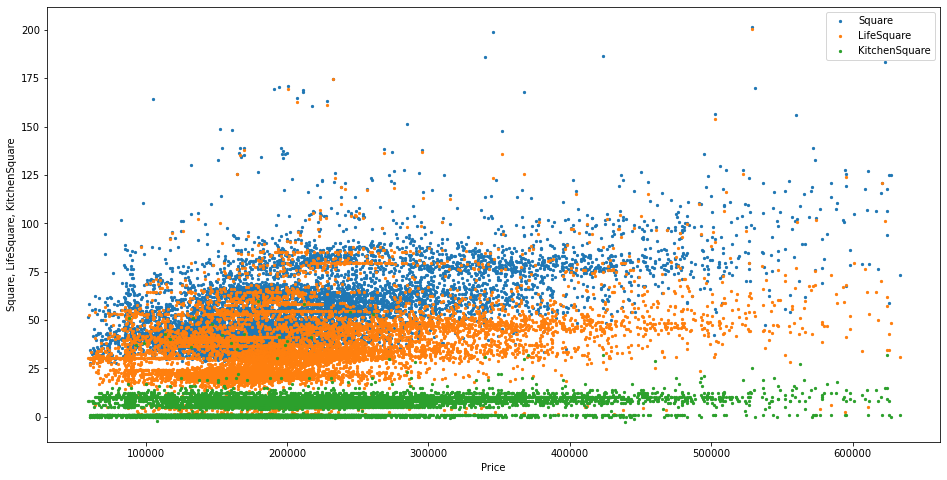

In [1164]:
# Square, LifeSqure, KitchenSquare
TypeSquares = ['Square', 'LifeSquare', 'KitchenSquare']

plt.figure(figsize=(16, 8))

for feature in TypeSquares:
    plt.scatter(y_train, X_train[feature], label=feature, s=5)

plt.xlabel('Price')
plt.ylabel('Square, LifeSquare, KitchenSquare')
plt.legend()
plt.show()

### 7. Building a model

In [1165]:
# cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

In [1166]:
#cv_score.mean()

In [1167]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

Train R2:	0.9335
Test R2:	0.769


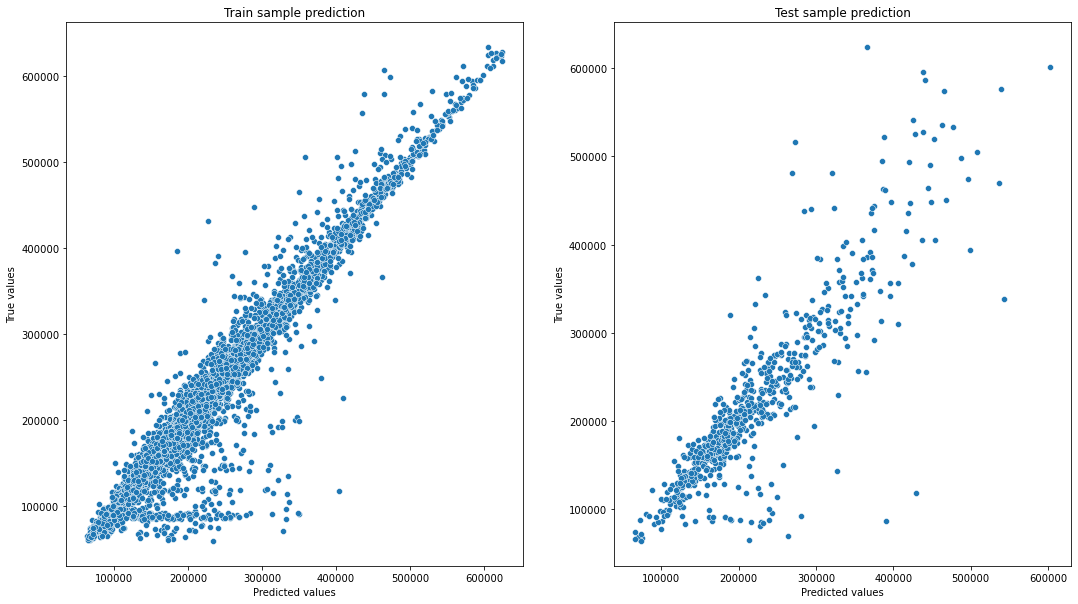

In [1168]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=3,
                                     n_estimators=1690,
                                     max_features='sqrt',
                                     loss='huber',
                                     random_state=42,
                                     learning_rate=0.024
                                    )
# max_depth:           7,    7,    8,    .,    9,
# min_samples_leaf:   27,    3,    4,    3,    .,
# n_estimators:     2090, 1690,    .,    .,    .,
# learning_rate:     024,    .,    .,    .,    .,
# Train R2:         8838, 9335, 9473, 9518, 9695,
# Test R2:          7573, 7690, 7659, 7626, 7621,
# Kaggle:                 7594.4            7521.5

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [1169]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
0             Square    0.240653
1              Rooms    0.138322
15     DistrictPrice    0.131377
16      DistrictSize    0.082710
2         LifeSquare    0.078358
4           Social_1    0.054951
5      KitchenSquare    0.039468
6          HouseYear    0.031500
3           Social_2    0.031469
17            Social    0.030566
7         HouseFloor    0.025136
18    DistrictSquare    0.021686
8           Social_3    0.017077
12       Helthcare_2    0.016485
9          Ecology_1    0.015017
10      Healthcare_1    0.014952
19      DistrictYear    0.011370
11           Shops_1    0.008246
14       Shops_1_cat    0.007357
13  Healthcare_1_cat    0.003300

### 8. Prediction on test dataset

In [1170]:
test_df.shape

(5000, 20)

In [1171]:
submit = pd.read_csv('./input/real_estate_price_prediction_moscow/sample_submission.csv')

In [1172]:
predictions = gb_model.predict(test_df)
predictions

array([164711.77963467, 115682.82752079, 137090.54264596, ...,
       149748.95757737, 181864.51932096, 287356.68777845])

In [1173]:
submit['Price'] = predictions
submit.head()

Id          Price
0  4567  164711.779635
1  5925  115682.827521
2   960  137090.542646
3  3848   98248.505339
4   746  183019.618915

In [1174]:
submit.to_csv('./input/real_estate_price_prediction_moscow/gb_submit.csv', index=False)

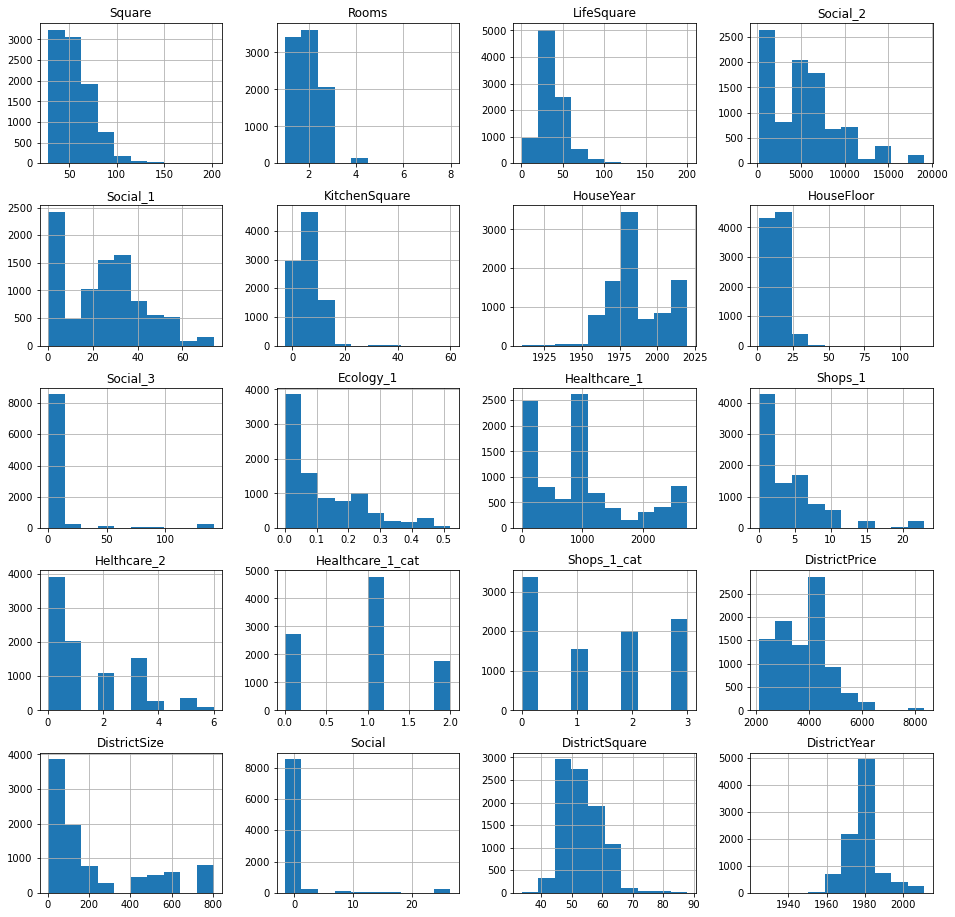

In [1175]:
num_f = list(X_train.select_dtypes(exclude='object').columns)
X_train[num_f].hist(figsize=(16, 16))
plt.show()

In [1176]:
train_df['Ecology_1'].describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

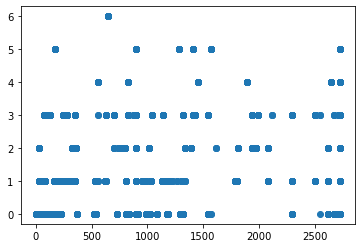

In [1177]:
plt.scatter(X_train['Healthcare_1'], X_train['Helthcare_2'])

In [1178]:
observation = pd.DataFrame({'train': y_train, 'pred': y_train_preds, 'Id': X_train['Id']}, columns=['Id', 'train', 'pred'])
observation['variance'] = 0
observation.loc[observation['pred'] >= observation['train'], 'variance'] = \
observation.loc[observation['pred'] >= observation['train'], 'train'] / observation.loc[observation['pred'] >= observation['train'], 'pred']
observation.loc[observation['pred'] < observation['train'], 'variance'] = \
observation.loc[observation['pred'] < observation['train'], 'pred'] / observation.loc[observation['pred'] < observation['train'], 'train']
observation['bad'] = 0
observation.loc[observation['variance'] > observation['variance'].quantile(0.05), 'bad'] = 1
observation[observation['bad'] == 1]

KeyError: 'Id'